<a href="https://colab.research.google.com/github/anna-marshalova/fall-detection/blob/main/fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Папка с весами модели](https://drive.google.com/drive/folders/1UNzfhx8gGIfSehoYAZIB0b5oqMVB8TxV)

Основная модель - `model.pt`.

#Imports and Preparations

In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=6ba96ee55729c926ad76067a085128cf63d52d299145608bc08aaa287ef651ac
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

In [2]:
import os
import gc
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Union, Sequence, Tuple, Callable

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import vgg19
from torchvision.transforms import transforms

import cv2

from roboflow import Roboflow

In [3]:
torch.set_default_dtype(torch.float32)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT = '/content/'
DRIVE_ROOT = '/content/drive/MyDrive/fall_detection'
os.makedirs(DRIVE_ROOT, exist_ok = True)

#Downloading Data

In [7]:
KEY_PATH = os.path.join(ROOT, 'roboflow_api_key.json')
with open(KEY_PATH) as key_json:
    roboflow_api_key = json.load(key_json)['key']

In [8]:
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("roboflow-universe-projects").project("fall-detection-ca3o8")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Fall-Detection-1 in yolov5pytorch:: 100%|██████████| 9006/9006 [00:02<00:00, 4080.79it/s]


#Preprocessing Data

In [9]:
DATA_DIR = os.path.join(ROOT, 'Fall-Detection-1')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')

##Dataset

In [10]:
class DetectionDataset(Dataset):

    def __init__(self, data_dir: str, transform=None):
        """
        :param data_dir: Путь к файлу с картинками и аннотациями
        :param transform:
        """
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.labels_dir = os.path.join(self.data_dir, 'labels')
        self.image_ids = sorted([fname.replace('.jpg', '') for fname in os.listdir(self.images_dir)])
        self.transform = transform

    def get_label(self, label_path: str) -> np.array:
        """
        Получение координат бокса в формате YOLO
        :param labels_path: Путь к файлу с разметкой
        :return: Массив с координатами (x_center, y_center, width, height)
        """
        # читаем координаты из файла
        with open(label_path) as label_file:
            labels = label_file.readlines()
        # ищем bbox с наибольшей площадью
        max_coordinates = [0, 0, 0, 0]
        max_area = 0
        for label in labels:
            # парсим координаты из строк файла (игнорируя метку класса на 0 месте)
            coordinates = [float(c) for c in label.strip().split()[1:]]
            width, height = coordinates[2:]
            area = abs(width * height)
            if area > max_area:
                max_coordinates = coordinates
                max_area = area
        return np.array(max_coordinates)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx: int) -> Dict[str, np.array]:
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        label_path = os.path.join(self.labels_dir, f'{image_id}.txt')
        image = cv2.imread(image_path)
        label = self.get_label(label_path)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
train_dataset = DetectionDataset(TRAIN_DIR)
val_dataset = DetectionDataset(VAL_DIR)
test_dataset = DetectionDataset(TEST_DIR)

## Visulaization

In [12]:
def display(sample: Dict[str, np.array], pred_bbox: Union[np.array, torch.tensor] = None):
    """
    Вывод картинки с боксами
    :param sample: Картинка и ground truth bbox
    :param pred_bbox: Предсказанный bbox
    """
    image, gt_bbox = sample.values()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # добавляем ground truth bbox и, если нужно, предсказанный bbox
    image = add_bbox(image, gt_bbox, border_color=[255, 255, 0])
    if pred_bbox:
        image = add_bbox(image, pred_bbox, border_color=[255, 0, 0])
    plt.imshow(image)


def add_bbox(image: np.array, yolo_coordinates_norm: Union[np.array, torch.tensor],
             border_color: Sequence = [0, 0, 0]) -> np.array:
    """
    Добавление бокса на изображение
    :param image: Изображение
    :param yolo_coordinates_norm: Координаты бокса в формате YOLO (нормализованные)
    :param border_color: Цвет бокса в формате RGB
    :return: Картинка с добавленным боксом
    """
    img_height, img_width = image.shape[:2]
    # вычисляем координаты углов бокса (нормализованные)
    corners_norm = get_corner_coordinates(yolo_coordinates_norm)
    # переводим координаты в абсолютные значения
    left, right, bottom, top = get_absolute_coordinates(corners_norm, img_height, img_width)
    # рисуем бокс на картинке
    cv2.rectangle(image, (left, top), (right, bottom), border_color, 1)
    return image


def get_corner_coordinates(yolo_coordinates: Union[np.array, torch.tensor]) -> Tuple[float]:
    """
    Получение координат углов из формата YOLO
    :param yolo_coordinates: Координаты в формате YOLO
    :return: Координаты углов
    """
    x, y, w, h = yolo_coordinates
    left = x - w / 2
    right = x + w / 2
    bottom = y - h / 2
    top = y + h / 2
    return left, right, bottom, top


def get_absolute_coordinates(coordinates_norm: Union[np.array, torch.tensor], img_height: int, img_width: int) -> Tuple[
    int]:
    """
    Перевод координат углов в абсолютные значения
    :param coordinates_norm:Нормализованные координаты углов
    :param img_height: Высота картинки
    :param img_width: Ширина картинки
    :return: Координаты в абсолютных значениях (left, right, bottom, top)
    """
    left, right, bottom, top = coordinates_norm
    return int(left * img_width), int(right * img_width), int(bottom * img_height), int(top * img_height)

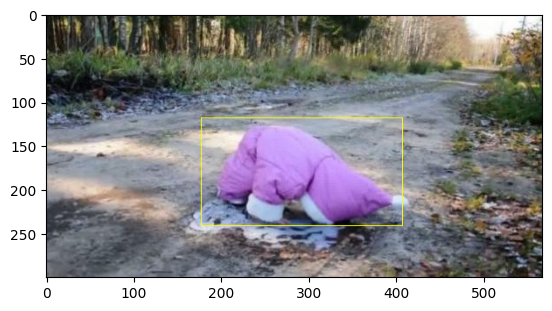

In [13]:
import random
i = random.randint(0, len(train_dataset))
display(train_dataset[i])

## Collator

In [14]:
def collate_fn(data):
    images = []
    labels = []
    WIDTH_LIMIT, HEIGHT_LIMIT = 500, 500
    max_width, max_height = 0, 0
    # ищем максимальную длину и ширину в батче
    for sample in data:
        height, width = sample['image'].shape[:2]
        if width > max_width:
            max_width = width
        if height > max_height:
            max_height = height
    # ограничиваем максимальную длину и ширину картинке (иначе картинки слишком большие и батчи не влезают на gpu)
    max_width = min(max_width, WIDTH_LIMIT)
    max_height = min(max_height, HEIGHT_LIMIT)

    # уравниваем размеры картинок
    for sample in data:
        image = sample['image']
        height, width = image.shape[:2]
        # пропорционально уменьшаем картинки, чтобы влезть в максималную длину/ширину
        if width > max_width:
            height = int(height / width * max_width)
            width = max_width
            image = cv2.resize(image, (width, height))
        if height > max_height:
            width = int((width / height) * max_height)
            height = max_height
            image = cv2.resize(image, (width, height))
        # добавляем паддинги для картинок, которые оказались меньше, чем нужно
        top = max(max_height - height, 0)
        left = max(max_width - width, 0)
        image = cv2.copyMakeBorder(image, top, 0, left, 0, cv2.BORDER_CONSTANT)
        # преобразуем данные в тензоры и собираем их в батчи
        images.append(torch.tensor(image, dtype=torch.float32))
        labels.append(torch.tensor(sample['label'], dtype=torch.float32))

    # перемещаем каналы на первое место
    return {'image': torch.stack(images).permute(0, 3, 1, 2), 'label': torch.stack(labels)}

##DataLoaders

In [15]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)

next(iter(train_loader))['image'].shape

torch.Size([8, 3, 500, 500])

#Model

In [20]:
class Detector(nn.Module):

    def __init__(self, pool_size: Tuple[int, int] = (2, 2), trainable_layers:int = 36):
        super().__init__()
        self.vgg = vgg19(weights='DEFAULT')
        self.features = self.vgg.features
        for layer in self.features[trainable_layers:]:
            layer.requires_grad_(False)
        self.avgpool = nn.AdaptiveAvgPool2d(pool_size)
        self.VGG_FEATURE_MAP_SIZE = 512 * pool_size[0] * pool_size[1]
        self.fc = nn.Linear(in_features=self.VGG_FEATURE_MAP_SIZE, out_features=4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.avgpool(self.features(x))
        features = features.flatten(1, 3)
        output = F.sigmoid(self.fc(features))
        return output

In [ ]:
#model = Detector()
# (batch_size, channels, height, width)
#model(torch.ones(2, 3, 128, 128))
#model(next(iter(train_loader))['image'])

#Metrics

##IoU

In [22]:
def calculate_iou(bbox1: torch.Tensor, bbox2: torch.Tensor) -> torch.Tensor:
    """
    Подсчет метрики IoU
    :param bbox1:
    :param bbox2:
    :return:
    """
    x1, y1, w1, h1 = bbox1[:, 0], bbox1[:, 1], bbox1[:, 2], bbox1[:, 3]
    left1, right1, bottom1, top1 = get_corner_coordinates((x1, y1, w1, h1))

    x2, y2, w2, h2 = bbox2[:, 0], bbox2[:, 1], bbox2[:, 2], bbox2[:, 3]
    left2, right2, bottom2, top2 = get_corner_coordinates((x2, y2, w2, h2))

    # ищем площадь пересечения
    intersection_left = torch.max(left1, left2)
    intersection_right = torch.min(right1, right2)
    intersection_bottom = torch.max(bottom1, bottom2)
    intersection_top = torch.min(top1, top2)
    intersection_width = torch.clamp(intersection_right - intersection_left, min=0)
    intersection_height = torch.clamp(intersection_top - intersection_bottom, min=0)
    intersection_area = intersection_width * intersection_height

    # ищем площадь объединения
    union_area = w1 * h1 + w2 * h2 - intersection_area

    iou = intersection_area / union_area

    return iou

##Precision and Recall

In [25]:
def confusion_matrix(gt_bboxes: torch.Tensor, pred_bboxes: torch.Tensor, iou_threshold: int = 0.5) -> Tuple[
    torch.Tensor]:
    """
    Подсчет TP, FP, FN
    :param gt_bboxes: ground truth боксы
    :param pred_bboxes: предсказанные боксы
    :param iou_threshold: порог IoU
    :return: TP, FP, FN
    """
    x_t, y_t, w_t, h_t = gt_bboxes[:, 0], gt_bboxes[:, 1], gt_bboxes[:, 2], gt_bboxes[:, 3]
    x_p, y_p, w_p, h_p = pred_bboxes[:, 0], pred_bboxes[:, 1], pred_bboxes[:, 2], pred_bboxes[:, 3]
    iou = calculate_iou(gt_bboxes, pred_bboxes)
    tp = torch.count_nonzero(iou >= iou_threshold)
    fp = torch.count_nonzero((iou < iou_threshold) & ((w_p * h_p) > 0))
    fn = torch.count_nonzero((iou < iou_threshold) & ((w_t * h_t) > 0))
    return tp, fp, fn


def precision(confusion_matrix: Tuple[torch.Tensor], decimal: int = 3) -> float:
    """
    Подсчет точности
    :param confusion_matrix: TP, FP, FN
    :param decimal: Степень округления
    :return: Точность
    """
    tp, fp, _ = confusion_matrix
    precision = (tp / (tp + fp))
    precision[precision != precision] = 0
    return round(precision.item(), decimal)


def recall(confusion_matrix: Tuple[torch.Tensor], decimal: int = 3) -> float:
    """
    Подсчет полноты
    :param confusion_matrix: TP, FP, FN
    :param decimal: Степень округления
    :return: Полнота
    """
    tp, _, fn = confusion_matrix
    recall = (tp / (tp + fn))
    recall[recall != recall] = 0
    return round(recall.item(), decimal)


def count_metrics(gt_bboxes: torch.Tensor, pred_bboxes: torch.Tensor, metrics: Sequence[str] = ['precision', 'recall'],
                  **kwargs) -> Dict[str, float]:
    """
    :param gt_bboxes: ground truth боксы
    :param pred_bboxes: предсказанные боксы
    :param metrics: Список метрик для подсчета
    :return: Словарь {название метрики: значение метрики}
    """
    METRICS_FN = {'precision': precision, 'recall': recall}
    cm = confusion_matrix(gt_bboxes, pred_bboxes, **kwargs)
    scores = {}
    for metric in metrics:
        fn = METRICS_FN[metric]
        scores.update({metric: fn(cm)})
    return scores

## Average Precision

In [26]:
def pr_curve(gt_bboxes: torch.Tensor, pred_bboxes: torch.Tensor, iou_step: float = 0.01) -> Tuple[np.array]:
    """
    Вычисление точек для Precision-Recall Curve
    :param gt_bboxes: ground truth боксы
    :param pred_bboxes: предсказанные боксы
    :param iou_step: Шаг порога IoU
    :return: Значения точности и полноты для каждого из значений порога
    """
    precision = []
    recall = []
    threshold = iou_step
    while threshold <= 1:
        p, r = count_metrics(gt_bboxes, pred_bboxes, iou_threshold=threshold).values()
        precision.append(p)
        recall.append(r)
        threshold += iou_step
    return np.array(precision), np.array(recall)


def plot_pr_curve(gt_bboxes: torch.Tensor, pred_bboxes: torch.Tensor, **kwargs):
    """
    Построение графика Precision-Recall Curve
    :param gt_bboxes: ground truth боксы
    :param pred_bboxes: предсказанные боксы
    """
    precision, recall = pr_curve(gt_bboxes, pred_bboxes, **kwargs)
    print(precision, recall)
    plt.plot(precision, recall)
    plt.show()


def average_precision(gt_bboxes: torch.Tensor, pred_bboxes: torch.Tensor, decimal: int = 3, **kwargs) -> float:
    """
    Подсчет метрики Average Precision
    :param gt_bboxes: ground truth боксы
    :param pred_bboxes: предсказанные боксы
    :param decimal: Степень округления
    :return: Average Precision
    """
    precision, recall = pr_curve(gt_bboxes, pred_bboxes, **kwargs)
    pr_df = pd.DataFrame({'precision': precision, 'recall': recall})
    # считаем среднее по точности для каждого значения полноты
    average_precision = pr_df.groupby('recall').max().precision.mean().round(decimal)
    return average_precision

In [ ]:
batch = next(iter(train_loader))
gt_bbox = batch['label']
image = batch['image']
pred_bbox = model(image)

In [ ]:
print(confusion_matrix(gt_bbox, pred_bbox))
print(count_metrics(gt_bbox, pred_bbox))
print(average_precision(gt_bbox, pred_bbox))

#Training

## One epoch

In [39]:
def train_one_epoch(model: nn.Module, dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
                    criterion: Callable) -> Tuple[float, float]:
    """
    Эпоха обучения модели
    :param model:
    :param dataloader:
    :param optimizer:
    :param criterion:
    :return: средний loss и среднее IoU за эпоху
    """
    model.train()

    train_running_loss = 0.0
    train_running_iou = 0
    batch_size = dataloader.batch_size
    total_epoch_steps = int(len(dataloader.dataset) / batch_size)

    tq = tqdm(enumerate(dataloader), total=total_epoch_steps)

    for step, batch in tq:
        images, target = batch.values()
        images, target = images.to(device), target.to(device)
        outputs = model(images)

        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        preds = model(images)
        train_running_iou += calculate_iou(target, preds).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        gc.collect()
        torch.cuda.empty_cache()

        tq.set_description(
            f"Train Loss: {train_running_loss / (step*batch_size + 1):.4f}, Train IoU: {train_running_iou / (step*batch_size + 1):.2f}")

    train_loss = train_running_loss / len(dataloader.dataset)
    train_iou = train_running_iou / len(dataloader.dataset)
    return train_loss, train_iou


def validate(model: nn.Module, dataloader: torch.utils.data.DataLoader, criterion: Callable) -> Tuple[float, float]:
    """
    Оценка модели на валидационных данных
    :param model:
    :param dataloader:
    :param criterion:
    :return: средний loss и среднее IoU
    """
    model.eval()

    val_running_loss = 0.0
    val_running_iou = 0
    batch_size = dataloader.batch_size

    with torch.no_grad():
        inference_steps = int(len(dataloader.dataset) / batch_size)
        tq = tqdm(enumerate(dataloader), total=inference_steps)

        for step, batch in tq:
            images, target = batch.values()
            images = images.to(device)
            target = target.to(device)

            outputs = model(images)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            preds = model(images)
            val_running_iou += calculate_iou(target, preds).sum().item()

            gc.collect()
            torch.cuda.empty_cache()

            tq.set_description(
                f"Val Loss: {val_running_loss / (step*batch_size + 1):.4f}, Val IoU: {val_running_iou / (step*batch_size + 1):.2f}")

        val_loss = val_running_loss / len(dataloader.dataset)
        val_accuracy = val_running_iou / len(dataloader.dataset)
        return val_loss, val_accuracy

## Trainining process

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Detector().to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
train_loss , train_iou = [], []

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    train_loss.append(train_epoch_loss)
    train_iou.append(train_epoch_iou)
    val_loss, val_iou = validate(model, test_loader, criterion)
    torch.save(model, os.path.join(DRIVE_ROOT, 'model.pt'))

##Hyperparameter Tuning

In [31]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def objective(trial):
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
  pool_size = (trial.suggest_int('pool_height', 1, 4), trial.suggest_int('pool_width', 1, 4))
  batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])
  #optim= trial.suggest_categorical('optimizer', ['adam'])
  loss = trial.suggest_categorical('loss', ['mse','mae'])
  use_weight_decay = trial.suggest_int('use_weight_decay', 0, 1)
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
  trainable_layers = trial.suggest_int('trainable_layers', 0, 36)

  #optimizers = {'adam':torch.optim.Adam, 'adamw':torch.optim.AdamW}
  losses = {'mse':nn.MSELoss, 'mae':nn.L1Loss}

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate_fn)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn = collate_fn)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Detector(trainable_layers=trainable_layers).to(device)
  criterion = losses[loss]()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay*use_weight_decay)

  train_epoch_loss, train_epoch_iou = train_one_epoch(model, train_loader, optimizer, criterion)
  val_loss, val_iou = validate(model, val_loader, criterion)
  return val_iou

In [ ]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="detection-model", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2023-07-13 04:53:12,360] A new study created in memory with name: detection-model
Train Loss: 0.0176, Train IoU: 0.08: 100%|██████████| 1574/1574 [07:38<00:00,  3.43it/s]
Val Loss: 0.0178, Val IoU: 0.31: : 57it [00:42,  1.33it/s]
[I 2023-07-13 05:01:36,060] Trial 0 finished with value: 0.3105234983232286 and parameters: {'learning_rate': 6.82407842709883e-05, 'pool_height': 3, 'pool_width': 1, 'batch_size': 2, 'optimizer': 'adamw', 'loss': 'mae', 'weight_decay': 0.0015498955191377143}. Best is trial 0 with value: 0.3105234983232286.
Train Loss: 0.0043, Train IoU: 0.17: 100%|██████████| 787/787 [07:29<00:00,  1.75it/s]
Val Loss: 0.0043, Val IoU: 0.35: : 57it [00:42,  1.34it/s]
[I 2023-07-13 05:09:56,188] Trial 1 finished with value: 0.35403438362810347 and parameters: {'learning_rate': 0.0001195730942971637, 'pool_height': 2, 'pool_width': 3, 'batch_size': 4, 'optimizer': 'adamw', 'loss': 'mse', 'weight_decay': 0.0047431786810463224}. Best is trial 1 with value: 0.35403438362810347.


##Testing

In [41]:
model = torch.load(os.path.join(DRIVE_ROOT, 'model.pt'))

In [42]:
test_loss, test_iou = validate(model, test_loader, criterion)

Val Loss: 0.0021, Val IoU: 0.48: : 57it [00:42,  1.34it/s]


tensor([0.6240], dtype=torch.float64, grad_fn=<DivBackward0>)


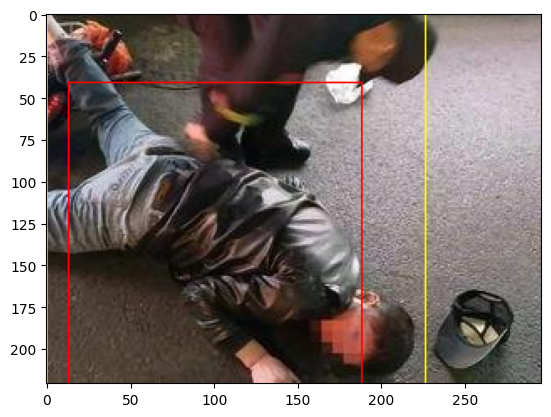

In [46]:
i = random.randint(0, len(test_dataset))
sample = test_dataset[i]
image, label = sample.values()
image_input = torch.tensor(image, dtype=torch.float).unsqueeze(0).permute(0,3,1,2).to(device)
pred_bbox = model(image_input).cpu()
print(calculate_iou(torch.tensor(label).unsqueeze(0), pred_bbox))
display(sample, pred_bbox = pred_bbox.view(4).tolist())